<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/07_minerva_computer_vision_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/07_minerva_computer_vision_example.ipynb)

# Introduction to Minerva

This notebook introduces the [Minerva framework](https://github.com/discovery-unicamp/Minerva) and demonstrates how to solve a computer vision task similar to the one covered in tutorials `03_pytorch_computer_vision.ipynb` and `06_lightning_computer_vision_example.ipynb` -- image classification.

As you'll see, Minerva is built on top of the Lightning API, and training a model with Minerva is very similar to doing so with Lightning.

## <a id="sec_1">1. Introduction</a>

### 1.1 Objective

The main objective of this tutorial is to simplify the transition from PyTorch to Minerva by guiding users through a computer vision task similar to those explored in the PyTorch-based (`03_pytorch_computer_vision.ipynb`) and Lightning-based (`06_lightning_computer_vision_example.ipynb`) tutorials.

Specifically, we will build, train, and evaluate a downstream machine learning model to solve the STL10 image classification task using the Minerva framework.
> Note: To ease the transition from Lightning, this tutorial focuses solely on the downstream task. 
  We will not cover pretraining a backbone using self-supervised learning (SSL) techniques at this stage.

### 1.2 The Minerva Framework

[Minerva](https://github.com/discovery-unicamp/Minerva) is a PyTorch-Lightning-based framework for training machine learning models, designed to support research and experimentation with self-supervised learning (SSL) methods. 

It provides a modular set of building blocks—such as backbones, projection and prediction heads, pretext tasks, loss functions, optimizers, and more—that can be composed to implement and evaluate various SSL techniques.

Minerva offers a wide range of features to support your machine learning projects:

* **Model Creation** -- Offers a variety of models and architectures to choose from.

* **Training and Evaluation** --  Provides tools to train and evaluate models, including loss functions, optimizers, and evaluation metrics.

* **Data Transformation** --  Includes tools for preprocessing and transforming data, such as data loaders, data augmentation, and normalization.

* **Modular Design** --  Designed to be modular and extensible, allowing easy integration of new features and functionalities.

* **Reproducibility** --  Ensures reproducibility with tools for versioning, configuration, and experiment logging.

* **Self-Supervised Learning (SSL) Support** --  Supports Self-Supervised Learning (SSL) for training models with limited labeled data.

* **Development Environment** --  Provides a pre-configured development environment with all dependencies installed.


#### 1.2.1 Key concepts

The figure below illustrates a self-supervised learning (SSL) framework.

First, a **pretext task** is used to train a **backbone**.
Once trained, this **pretrained backbone** is then used as part of the target model, which is trained to solve the **downstream (or target)** task.
> Note: In this tutorial, we will focus solely on the downstream task and will not cover the pretraining phase.
To that end, we will use a ResNet50 model pre-trained on the ImageNet dataset as the backbone.

![SSL overview](https://raw.githubusercontent.com/eborin/SSL-course/main/images/07-fig-backbone-projector-predictor.png)

The **Backbone** is also known as the feature extractor or representation extractor.
This is typically a machine learning model (or a subset of its layers) used to encode input data into meaningful representations.
As illustrated in the previous figure, it is tipically combined with other components (e.g., a projection head) and trained in the pretext task.

The **Pretext task** is a training task designed to learn useful representations in an unsupervised manner—i.e., without requiring manually labeled data.

The **Projection head** is a model component (tipically, layers) appended to the backbone during pretext training, enabling the model to solve the pretext task.

The **Downstream task**, also called the target task, is usually a supervised learning task trained using labeled data. 
It is designed to train the downstream model to solve the target task.

The **Prediction head** is a model component (tipically layers) attached to the backbone to compose the downstream model.

The **Downstream model** is the model designed to solve the target task. It is usually composed of a pretrained backbone and a prediction head, which are further refined (trained) using the target dataset.

#### 1.2.2 Minerva structure

Minerva is organized into the following key modules:

1. **data**: The [`minerva.data`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/data/index.html) module includes classes for reading and constructing datasets, as well as building data modules.
Refer to the [README.md](https://github.com/discovery-unicamp/Minerva/blob/main/minerva/data/README.md) file for a list of available dataset readers.
    > Note: In this notebook we use the [MinervaDataModule](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/data/data_modules/base/index.html#minerva.data.data_modules.base.MinervaDataModule) to manage the training, validation, and test splits of the STL dataset.

2. **models**: The [`minerva.models`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/models/index.html) module provides model components, including backbones, heads, and pretext task implementations.
See the [README.md](https://github.com/discovery-unicamp/Minerva/blob/main/minerva/models/README.md)  for details on supported SSL techniques.
This module is divided into two submodules:
  - **`nets`**: Contains components like backbones, prediction heads, and projection heads, along with tools for building downstream models.
  - **`ssl`**: Includes models that implement pretext tasks used during the pretraining of backbones.
    > Note: This notebook utilizes the [`SimpleSupervisedModel`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/models/nets/base/index.html#minerva.models.nets.base.SimpleSupervisedModel) to build a supervised model with a backbone and a prediction head.

3. **losses**: The [`minerva.losses`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/losses/index.html) module provides a collection of loss functions commonly used in SSL tasks.

4. **optimizers**: The [`minerva.optimizers`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/optimizers/index.html) module offers implementations of alternative optimizers.
    > Note: Minerva is fully compatible with PyTorch and PyTorch Lightning optimizers. Users are encouraged to reuse existing optimizers rather than reimplementing them.

5. **transforms**: The [`minerva.transforms`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/transforms/index.html) module includes a suite of dataset transformations, useful for data augmentation—particularly in contrastive SSL setups.

6. **pipelines**: The [`minerva.pipelines`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/pipelines/index.html) module offers utilities for structuring training and evaluation in a reproducible manner.

7. **analysis**: The [`minerva.analysis`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/analysis/index.html) module provides tools for performance evaluation and visualization.

8. **callback**: The [`minerva.callback`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/callback/index.html) module contains PyTorch Lightning-based callbacks for training monitoring and logging.

9. **samplers**: The [`minerva.samplers`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/samplers/index.html) module includes advanced data samplers to support complex sampling strategies.

10. **utils**: The [`minerva.utils`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/utils/index.html) module provides general-purpose utility functions and classes.

#### 1.2.3 Training backbones with SSL

To pretrain a backbone with minerva, you may follow these steps:

##### Instantiate the backbone

First, you need an instance of a backbone to be pretrained. 
Backbones are PyTorch models and can be reused in Lightning and Minerva workflows. A variety of backbone architectures are implemented within the models module.

##### Build the Minerva SSL model

Minerva provides several SSL models under the `models.ssl` submodule. 
These models typically accept a backbone and, optionally, a projection head, to configure the pretext task.

##### Setup the data modules

Depending on the SSL method, a data module should be instantiated with an appropriate dataset. 
The dataset may be labeled or unlabeled and often includes augmentation transformations suited to the SSL technique.
Minerva `data` module includes classes for reading and constructing datasets, as well as building data modules. Also, Minerva `transforms` module includes a suite of dataset transformations, useful for data augmentation—particularly in contrastive SSL setups.

##### Training the model

Once the SSL model and datamodule are set up, use the PyTorch Lightning Trainer's `fit()` method to start the pretraining process.

#### 1.2.4 Building and Refining a Downstream Model with a Pretrained Backbone

After pretraining a backbone, it can be leveraged to construct a downstream model—i.e., a model tailored for a specific supervised task. 
This downstream model is then trained using labeled data in a fully supervised manner.

There are multiple strategies for assembling a downstream model from a pretrained backbone. 
A common approach involves attaching a prediction head to the backbone, forming a complete architecture for the target task.

In this tutorial, we utilize the [`SimpleSupervisedModel`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/models/nets/index.html#minerva.models.nets.SimpleSupervisedModel) class provided by Minerva. 
This utility simplifies the process of building supervised models by seamlessly integrating a backbone with a prediction head.



### 1.3 Importing Minerva



To import the Minerva module, you must first install it.
If you already installed the modules in the `requirements.txt` file, Minerva is already installed.
If not, you may install Minerva using `pip` by running the following command on your terminal:

```bash
pip install minerva-ml
```

We recommend installing all the packages in `requirements.txt`. To do so, you may run the following command on your terminal:

```bash
pip install -r requirements.txt
```

For your convenience, the following code tries to import Minerva module and, if it fails, it tries to install it and import again (It should work on Google Colab).

In [5]:
try:
    import minerva
except:
    try:
        #Try to install it and import again
        print("[INFO]: Could not import the minerva module. Trying to install it!")
        !pip install -q minerva-ml
        import minerva
        print("[INFO]: It looks like minerva was successfully imported!")
    except:
        raise Exception("[ERROR] Couldn't find the minerva module ... \n" +
                        "Please, install it before running the notebook.\n"+
                        "You might want to install the modules listed at requirements.txt\n" +
                        "To do so, run: \"pip install -r requirements.txt\"")

### 1.4 What we're going to cover

In this tutorial, we’ll demonstrate how to use the [Minerva framework](https://github.com/discovery-unicamp/Minerva) to build and train a model for a computer vision task. 
Specifically, we will build a supervised model by combining a pretrained backbone (ResNet50 from `torchvision`) with a prediction head and train them so solve the STL10 image classification task using the Minerva framework.

| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Basic setup**](#sec_2) | Import useful modules (torch, torchvision, and lightning). |
| [**3. Getting the dataset and datamodule ready**](#sec_3) | Download the dataset and split the train set into train and validation subsets and create the `datamodule`. |
| [**4. Building a Minerva SimpleSupervisedModel**](#sec_4) | Build a minerva `SimpleSupervisedModel` to solve the computer vision task. |
| [**5. Training the model**](#sec_5) | Train and check the model performance. |
| [**6. Predicting with the trained model**](#sec_6) | Perform predictions with the trained model. |
| [**7. Exercises**](#sec_7) | Suggested Exercises. |

### 1.5 Where can you get help?

In addition to discussing with your colleagues or the course professor, you might also consider:

* PyTorch: check the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and research or post PyTorch related question on the [PyTorch developer forums](https://discuss.pytorch.org/).

* Lightning: check the [Lightning documentation](https://lightning.ai/docs/overview/getting-started) and research or post Lightning related question on the [PyTorch Lightning forum](https://lightning.ai/forums/).

* Minerva: check the [Minerva docs](https://discovery-unicamp.github.io/Minerva/).


## <a id="sec_2">2. Basic setup</a>

Let's import the basic modules, such as lightning, torch, and other utility modules.

In [6]:
# Import PyTorch
import torch

# Import torchvision
import torchvision

# Import lightning
import lightning as L

# Import minerva
import minerva

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"Lightning version: {L.__version__}")
#print(f"Minerva version: {M.__version__}") ## TODO

# Import matplotlib for visualization
import matplotlib.pyplot as plt

PyTorch version: 2.6.0
torchvision version: 0.21.0
Lightning version: 2.5.0.post0


Like we did in the Lightning tutorial, let's skip selecting the target device and just focus on defining our set_seed() function. We'll use PyTorch Lightning's `seed_everything()` utility to handle seed setting in a clean and consistent way.

In [7]:
# Auxiliary function to set both the CPU and GPU seeds
def set_seed(seed):
    L.seed_everything(seed)

## <a id='sec_3'>3. Getting the dataset and datamodule ready</a>

### 3.1 Getting the STL10 dataset

As in the previous tutorial, we will use `torchvision` to get the dataset.
However, instead of FashionMNIST, we will work with STL10.

In [8]:
# Setup training data
train_dataset = torchvision.datasets.STL10(root="data",
                                           split="train",
                                           download=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           target_transform=None)

# Setup test data
test_dataset = torchvision.datasets.STL10(root="data",
                                          split="test",
                                          download=True,
                                          transform=torchvision.transforms.ToTensor(),
                                          target_transform=None)

class_names = train_dataset.classes

### 3.2 Partitioning the STL10 training set

Alright. Now, let's split the train_dataset into train and validation sets.

In [9]:
from torch.utils.data import random_split

set_seed(42)

# Define split sizes (e.g., 80% training, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_data, val_data = random_split(train_dataset, [train_size, val_size])

Seed set to 42


### 3.3 Setting Up the Minerva DataModule

Now that we have the train, validation, and test splits, let's build the `MinervaDataModule`.

Minerva DataModules are conceptually similar to PyTorch Lightning DataModules — they encapsulate the training, validation, and test DataLoaders in a single, organized class.
While neither Minerva nor Lightning require the use of a DataModule, they help structure the code more cleanly.

As we saw in the previous tutorial, it's perfectly valid to instantiate and use PyTorch DataLoaders directly.
However, using a DataModule simplifies things by centralizing the data loading logic.
Additionally, the trainer object can automatically access the appropriate DataLoader (e.g., for training or testing) from the DataModule.

The following code defines the `MinervaDataModule` using the datasets we prepared earlier:

In [10]:
from minerva.data.data_modules.base import MinervaDataModule

data_module = MinervaDataModule(name="STL10",
                                train_dataset=train_data,
                                val_dataset=val_data,
                                test_dataset=test_dataset,
                                batch_size=32, num_workers=7)

print(data_module)

                      🆔 STL10
├── Predict Split: test
└── Dataloader class: <class 'torch.utils.data.dataloader.DataLoader'>
📂 Datasets:
   ├── Train Dataset:
   │      <torch.utils.data.dataset.Subset object at 0x14aef4ec0>
   ├── Val Dataset:
   │      <torch.utils.data.dataset.Subset object at 0x16810ad50>
   └── Test Dataset:
          Dataset STL10
              Number of datapoints: 8000
              Root location: data
              Split: test
              StandardTransform
          Transform: ToTensor()

🛠 **Dataloader Configurations:**
   ├── Train Dataloader Kwargs:
         ├── batch_size: 32
         ├── num_workers: 7
         ├── shuffle: true
         ├── drop_last: false
   ├── Val Dataloader Kwargs:
         ├── batch_size: 32
         ├── num_workers: 7
         ├── shuffle: false
         ├── drop_last: false
   └── Test Dataloader Kwargs:
         ├── batch_size: 32
         ├── num_workers: 7
         ├── shuffle: false
         ├── drop_last: false


Nice! Our DataModule contains three datasets: Train, Val, and Test.

### 3.4 Inspecting one of the samples


Let's access one of the datasets and inspect one of its samples.

In [11]:
test_ds = data_module.test_dataset

# Inspect the first sample from test_ds
sample = test_ds[0]
print("sample[0] - features shape:", sample[0].shape)
print("sample[0] - label:", sample[1], f"({class_names[sample[1]]})")

sample[0] - features shape: torch.Size([3, 96, 96])
sample[0] - label: 6 (horse)


Alright. Now, lets plot the image.

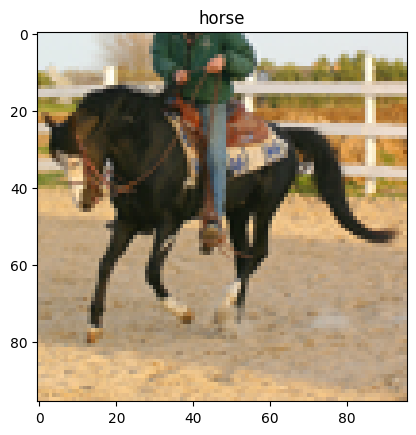

In [12]:
image, label = sample
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.show()

## <a id='sec_4'>4. Building a Minerva SimpleSupervisedModel</a>

Minerva was originally designed to support research in self-supervised learning methods.
In this context, downstream models are typically structured using two main components: a backbone and a head (either a projection head or a prediction head).


### 4.1 Backbone

We'll start by defining the model's backbone.
To do this, we'll reuse the ResNet50 architecture from `torchvision`, as demonstrated in the earlier tutorial `05_pytorch_transfer_learning`.

> Note: In a typical Minerva workflow, this backbone would be pretrained using a self-supervised learning (SSL) technique. 
However, to keep the transition from PyTorch/Lightning to Minerva straightforward, we're using an already pretrained ResNet50 model for this tutorial.

In [13]:
from torchvision.models import resnet50, ResNet50_Weights

backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
backbone.fc = torch.nn.Identity() # Remove classifier layer from the backbone

Let's check the shape of the features our backbone produces when processing one of our samples.

In [14]:
# Model expects a batch dimension. Unsqueeze(0) to add this dimension.
input = sample[0].unsqueeze(0)
features = backbone(input)

print("input data shape       :", input.shape)
print("computed features shape:", features.shape)

input data shape       : torch.Size([1, 3, 96, 96])
computed features shape: torch.Size([1, 2048])


Alright, the backbone has processed a batch with one `3x96x96` input tensor and produced a batch with one 2048-dimensional feature vector.

### 4.2 Prediction Head

Now, let's build the prediction head.
For this experiment, we'll keep it simple and use a single linear layer.
As expected, the prediction head should accept a 2048-dimensional input (the output from the backbone) and produce an output vector with `len(class_names)` values—one for each class.

In [15]:
prediction_head = torch.nn.Linear(2048, len(class_names))

### 4.3 The [`SimpleSupervisedModel`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/models/nets/index.html#minerva.models.nets.SimpleSupervisedModel)

Now that we have both a backbone and a prediction head, we can assemble the full model.
There are several ways to do this, but we'll use the `SimpleSupervisedModel` class—a convenient utility provided by `minerva` for building supervised models.

The [`SimpleSupervisedModel`](https://discovery-unicamp.github.io/Minerva/autoapi/minerva/models/nets/index.html#minerva.models.nets.SimpleSupervisedModel) class takes a backbone and a head as input, combining them into a complete end-to-end model.
In addition, it allows you to specify the loss function and evaluation metrics to be used during training and validation.
> Note: Minerva can use metrics from the `torchmetrics` library to evaluate model performance. 
In this example, we are using the `Accuracy` metric provided by `torchmetrics`.
For more information on `torchmetrics`, you may check [https://lightning.ai/docs/torchmetrics/stable](https://lightning.ai/docs/torchmetrics/stable/).

In [16]:
from minerva.models.nets.base import SimpleSupervisedModel
from torchmetrics import  Accuracy

simple_resnet = SimpleSupervisedModel(
    backbone=backbone,
    fc=prediction_head,
    loss_fn=torch.nn.CrossEntropyLoss(),
    train_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    val_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    test_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
)

/Users/edson/Desktop/2025-Ensino-MO810/2025-MO810-SSL/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='sec_5'>5. Training the model</a>

To train the model, we simply create a Lightning Trainer object and call its `fit()` method—just as we would in any standard Lightning workflow.

This time, we will configure the `Trainer` to log information to the `logs/07_minerva` directory. 
To achieve this, we will instantiate a `TensorBoardLogger` and pass it to the Trainer during its creation.

> Note: In the following code block, you can adjust the maximum number of epochs to balance between execution time and model accuracy, depending on your specific needs.

In [ ]:
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

trainer = Trainer(max_epochs=20, log_every_n_steps=8,
                  logger = TensorBoardLogger(save_dir="logs/07_Minerva/", name="SimpleSupervisedModel"))

trainer.fit(simple_resnet, data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Linear           | 20.5 K | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
153       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/edson/Desktop/2025-Ensino-MO810/2025-MO810-SSL/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/edson/Desktop/2025-Ensino-MO810/2025-MO810-SSL/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 4: 100%|██████████| 125/125 [01:35<00:00,  1.32it/s, v_num=0, val_loss=0.681, val_accuracy=0.769, train_loss=0.225, train_accuracy=0.922]

Now we can test the model using the Trainer `test()` method.

In [ ]:
trainer.test(simple_resnet, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 250/250 [00:03<00:00, 71.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.784375011920929     │
│         test_loss         │    0.8935132622718811     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8935132622718811, 'test_accuracy': 0.784375011920929}]

Done!

Once again, not much different from the previous tutorials.

### 5.1 Monitoring training statistics with TensorBoard

As discussed in our previous tutorials, it's often helpful to track training statistics—such as training and validation loss—throughout the training process.

Once you execute the previous code, you will find a folder named `logs/07_Minerva/SimpleSupervisedModel/` with all logs in your working directory.

Each time you run the Trainer, a new subfolder is created inside `logs/07_Minerva/SimpleSupervisedModel/`, containing all the logging information and model checkpoints generated by the training or testing processes.

As discussed in tutorial `06_lightning_computer_vision_example.ipynb`, a common way to view these logs is by using TensorBoard, a tool that reads the contents of these folders and displays the data in clear, interactive charts.

The following image shows the TensorBoard dashboard with statistics collected by the previous training process.

![Training statistics on TensorBoard](https://raw.githubusercontent.com/eborin/SSL-course/main/images/07-tensorboard-1.png)

If you want to monitor training performance in real time while the Trainer is running, you can click the reload icon in the TensorBoard interface.
This will refresh the view by re-reading the log files and updating the charts accordingly.

## <a id="sec_6">6. Predicting with the trained model</a>

The minerva `SimpleSupervisedModel` class supports prediction with the trainer `predict()` method.
For each item in the dataloader, it computes the values produced by the prediction head and return them on a list.

Let's use the trained model to predict the values in the test set.

In [ ]:
preds = trainer.predict(simple_resnet, data_module.test_dataloader())

print("type(preds):", type(preds))
print("len(preds) :", len(preds))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 250/250 [00:02<00:00, 87.36it/s]
type(preds): <class 'list'>
len(preds) : 250


By default, the `MinervaDataModule` returns the `test` set for predictions. Hence, the following command would have the same effect as the previous one:

```python
preds = trainer.predict(simple_resnet, data_module)
```

Alright, now, let's convert these logits into labels.

In [ ]:
# Concatenate all prediction tensors
all_preds = torch.cat(preds)

# Run argmax on the concatenated tensor
predicted_labels = torch.argmax(all_preds, dim=1)

predicted_labels = predicted_labels.cpu().numpy()

predicted_labels

array([6, 4, 3, ..., 8, 9, 8])

Finally, lets print the confusion matrix.

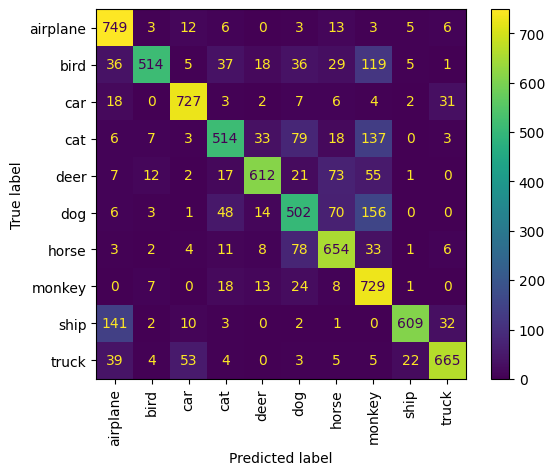

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#get only the labels from the test dataset
true_labels = [label for _, label in data_module.predict_dataset]

cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation="vertical")

## <a id="sec_7">7. Exercises</a>

While there is no designated exercise for this tutorial, the following activities can help you familiarize with Minerva.

* **Metrics**: Change the previous code to report other metrics during model training and testing.

* **Checkpoints**: Modify the previous code to save checkpoints according to (i) the smallest validation loss, (ii) highest validation accuracy, and (iii) smallest training loss. Then, load these checkpoints and compare the respective model performances.

* **Early stopping**: Configure the trainer with an Early stopping mechanism. To do so, explore Lightning the [EarlyStopping callback](https://lightning.ai/docs/pytorch/stable/common/early_stopping.html), and modify the previous code to train for up to 30 epochs, but stop early if the validation accuracy does not improve for 2 consecutive epochs.